# Bu Tensorflow API orqali tuzulgan model


*I used tensorflow dataset to build my model*

In [ ]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50,preprocess_input
import cv2

In [ ]:
train,test = tfds.load("dtd",split=['train[:90%]','train[90%:]'],batch_size=-1)
print('Shares : \n' )
print(f"Overall : {len(train)+len(test)} images ;\n\n Train : {len(train)} images  ;\n\n Test : {len(test)} images ;")

Shares : 

Overall : 6 images ;

 Train : 3 images  ;

 Test : 3 images ;


In [ ]:
datas = tfds.builder('dtd')
info = datas.info
print(info)

tfds.core.DatasetInfo(
    name='dtd',
    full_name='dtd/3.0.1',
    description="""
    The Describable Textures Dataset (DTD) is an evolving collection of textural
    images in the wild, annotated with a series of human-centric attributes,
    inspired by the perceptual properties of textures. This data is made available
    to the computer vision community for research purposes.
    
    The "label" of each example is its "key attribute" (see the official website).
    The official release of the dataset defines a 10-fold cross-validation
    partition. Our TRAIN/TEST/VALIDATION splits are those of the first fold.
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/dtd/index.html',
    data_path='/root/tensorflow_datasets/dtd/3.0.1',
    file_format=tfrecord,
    download_size=596.28 MiB,
    dataset_size=603.00 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': C

In [ ]:
list(info.splits.keys())

['train', 'test', 'validation']

In [ ]:
num_classes = info.features['label'].num_classes
labels = []
for i in range(num_classes):
    labels.append(info.features['label'].int2str(i))
len(labels)

47

In [ ]:
sample = tfds.load("dtd",split='train[95%:]',shuffle_files=True)

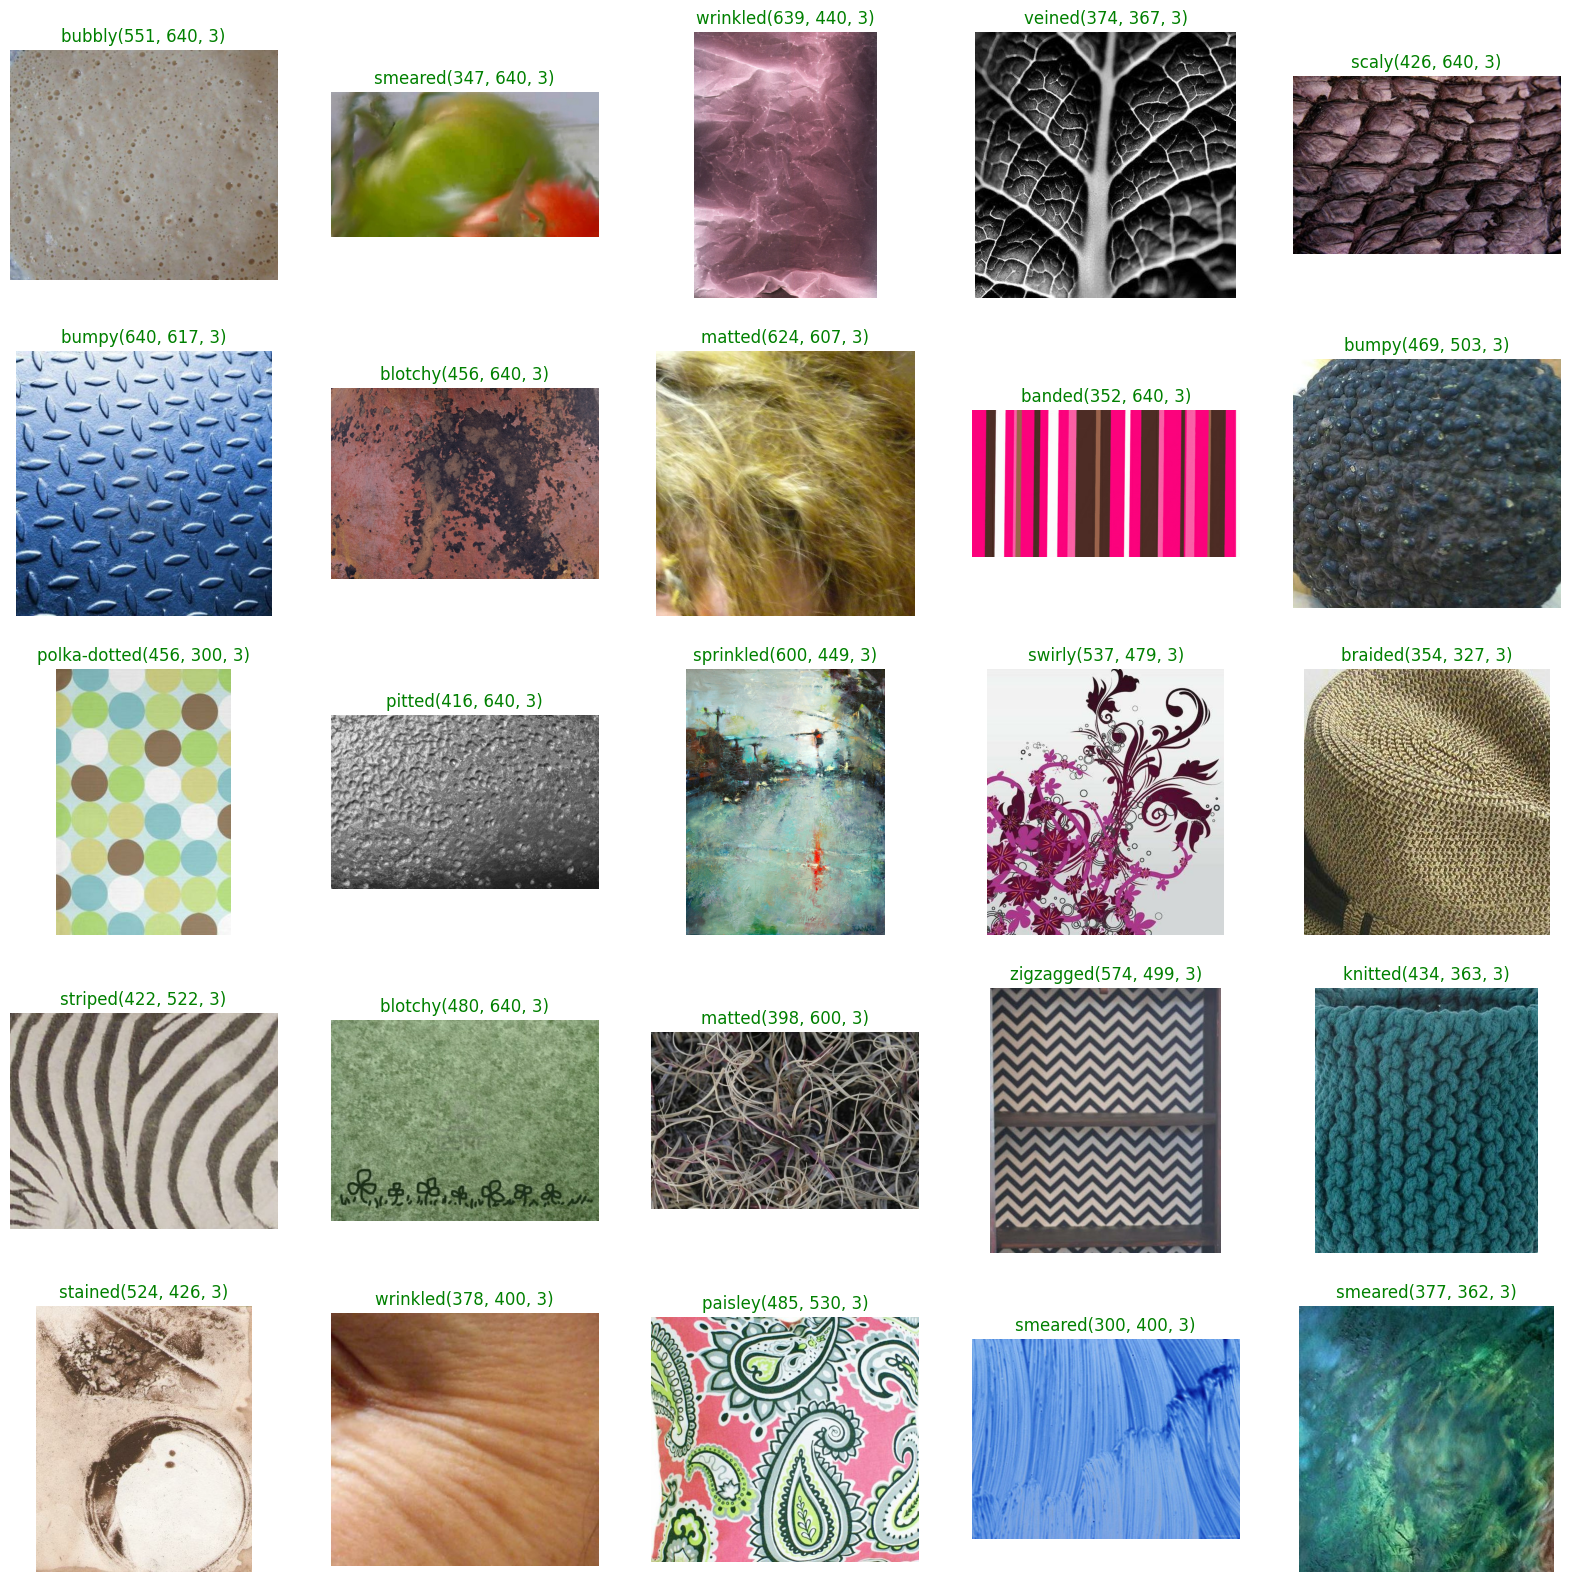

In [ ]:
plt.figure(figsize=(20,20))
random_state = 36
for i,data in enumerate(tfds.as_numpy(sample.take(25))):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(data['image'])
    plt.title(labels[data['label']]+str(data['image'].shape),color='green')
    plt.axis("off")
plt.show()

In [ ]:
train_images,train_labels = tfds.as_numpy(train['image']),tfds.as_numpy(train['label'])
test_images,test_labels = tfds.as_numpy(test['image']),tfds.as_numpy(test['label'])

In [ ]:
def resizing(images):
    im_data = []
    for image in images:
      img = cv2.resize(image,(224,224),interpolation=cv2.INTER_AREA)
      im_data.append(img)
    return im_data
def preprocess(imgs,labs):
    imgs = np.array(imgs)
    imgs = imgs/255.0
    imgs = imgs.astype('float32')
    labs = np.array(labs)
    label = labs.astype("uint32")
    return imgs,label

In [ ]:
x_train = resizing(train_images)
x_test = resizing(test_images)
x_train,y_train = preprocess(x_train,train_labels)
x_test,y_test = preprocess(x_test,test_labels)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)

In [ ]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint32, name=None))>

In [ ]:
BATCH_SIZE = 64
Epochs = 300
num_classes = len(labels)

In [ ]:
model_1 = tf.keras.applications.ResNet50(weights='imagenet' ,input_shape=(224,224,3),include_top=False)

In [ ]:
model_1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
for i in model_1.layers:
    i.trainable=False

In [ ]:
model_1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
class Madel(tf.keras.Model):
    def __init__(self):
        super(Madel,self).__init__()
        self.resnet = model_1
        self.flatten1 = tf.keras.layers.Flatten()
        self.dense_1 = tf.keras.layers.Dense(2048,activation='relu')
        self.dense_2 = tf.keras.layers.Dense(512,activation='relu')
        self.dense_3 = tf.keras.layers.Dense(num_classes,activation='softmax')
    def call(self,x):
        x = self.resnet(x)
        x = self.flatten1(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.dense_3(x)
model = Madel()

In [ ]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=Adam,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import Callback
class myCallback(Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get("accuracy")>0.9):
            print("\n accuracy reached the highest point,cancelling session")
            self.model.stop_training=True
Callback = myCallback()

In [ ]:
STEPS_PER_EPOCH = int(info.splits['train'].num_examples * 0.8) // BATCH_SIZE
train_ds = train_ds.repeat()

history = model.fit(train_ds,epochs=Epochs,batch_size=BATCH_SIZE,steps_per_epoch = STEPS_PER_EPOCH,callbacks=Callback)

Epoch 1/300
23/23 [==============================] - 22s 128ms/step - loss: 27.6647 - accuracy: 0.0122
Epoch 2/300
23/23 [==============================] - 3s 123ms/step - loss: 6.2659 - accuracy: 0.0217
Epoch 3/300
23/23 [==============================] - 4s 173ms/step - loss: 4.1946 - accuracy: 0.0410
Epoch 4/300
23/23 [==============================] - 3s 124ms/step - loss: 3.8691 - accuracy: 0.0394
Epoch 5/300
23/23 [==============================] - 3s 124ms/step - loss: 3.8574 - accuracy: 0.0342
Epoch 6/300
23/23 [==============================] - 3s 126ms/step - loss: 3.7982 - accuracy: 0.0394
Epoch 7/300
23/23 [==============================] - 3s 128ms/step - loss: 3.7848 - accuracy: 0.0478
Epoch 8/300
23/23 [==============================] - 3s 125ms/step - loss: 3.7531 - accuracy: 0.0462
Epoch 9/300
23/23 [==============================] - 3s 124ms/step - loss: 3.7254 - accuracy: 0.0571
Epoch 10/300
23/23 [==============================] - 3s 125ms/step - loss: 3.7301 - accu

In [ ]:
model.evaluate(test_ds)

6/6 [==============================] - 2s 101ms/step - loss: 5.6509 - accuracy: 0.1543


[5.6508660316467285, 0.15425531566143036]

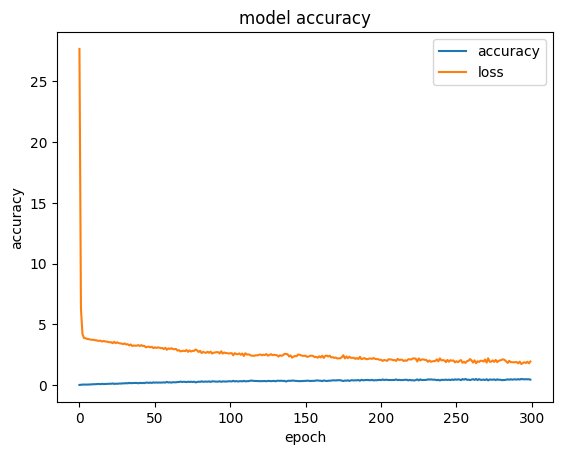

In [ ]:
def plotting(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["loss"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["accuracy", "loss"], loc="best")
    plt.show()
plotting(history)

In [ ]:
model.save("Resnet_transfer.model",save_format = 'tf')